Embedding Tests
===

In [1]:
import json
import os
import time
from pathlib import Path

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd
import pyserini
import scipy
import sklearn.metrics
import tiktoken
from pyserini.search.lucene import LuceneSearcher
from tqdm import tqdm

In [2]:
dotenv.load_dotenv("../.env")

True

In [3]:
os.environ["OPENAI_API_KEY"][:3]

'sk-'

In [4]:
openai.api_key = os.environ["OPENAI_API_KEY"]

In [5]:
data_dir = Path("../data")
assert data_dir.exists()
with open(data_dir / "derived" / "rori_lessons.json") as infile:
    df = pd.read_json(infile)
df.shape

(67, 18)

In [6]:
embedding_dir = data_dir / "derived" / "embeddings"
embedding_dir.mkdir(exist_ok=True)

In [7]:
df.iloc[0].short_description, df.iloc[0].lesson_parts

('Let us learn how to add and subtract linear expressions with 2 or more variables.',
 ['Linear expressions are variables that are combined using the signs of addition, subtraction, multiplication and division. \nThey can be added or subtracted by combining the like terms. \n\nLike terms are terms which contain the same variable raised to the same power.\nUnlike terms are terms that have the same variable and are not raised to the same power.\n\nWhen adding polynomials, simply drop the parenthesis and combine like terms. \nWhen subtracting polynomials, distribute the minus sign first, then combine like terms.\n\nLet us check out an example!\n\nWrite *Yes* to continue.',
  'Example:\n\nQues: Simplify the expression below:\n(3x + 4y) - (2x + 5y)\nA. x - y\nB. 5x - y\nC. 2x- y\nD. x - y\n\nHint: \nDistribute the negative sign to 2x + 5y.\n3x + 4y - 2x - 5y\n= (3x - 2x) + (4y - 5y)\n= x - y\n\nAns: A\n\nWould you like to try some questions?\n\nWrite *Yes* to continue.'])

In [9]:
ds = []
ada_tokeniser = tiktoken.encoding_for_model("text-embedding-ada-002")
for row in df.itertuples():
    lesson_code = row.lesson_code
    db_string = row.short_description + "\n\n" + "\n\n".join(row.lesson_parts)
    db_string_token_count = len(ada_tokeniser.encode(db_string))
    ds.append(
        {
            "lesson_code": lesson_code,
            "grade": row.grade,
            "db_string": db_string,
            "db_string_token_count": db_string_token_count,
        }
    )
embed_df = pd.DataFrame(ds)

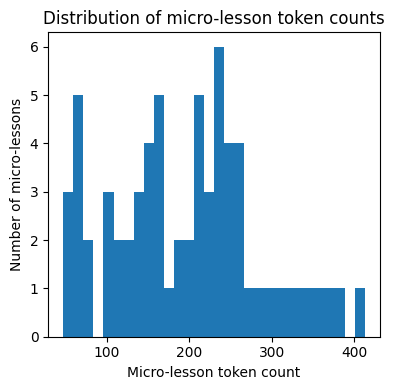

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.hist(embed_df.db_string_token_count, bins=30)
ax.set_title("Distribution of micro-lesson token counts")
ax.set_xlabel("Micro-lesson token count")
ax.set_ylabel("Number of micro-lessons")

fig.tight_layout()
plt.show()

In [11]:
embed_df.sort_values(by="db_string_token_count").head(10)

,lesson_code,grade,db_string,db_string_token_count
28,G6.N1.3.3.5,6,In today's lesson we are going to solve word p...,47
49,G6.N3.1.1.4,6,Even decimal numbers have place values . Let u...,54
27,G6.N1.3.3.4,6,Let us multiply a 3 and 4 digit number with re...,55
26,G6.N1.3.3.3,6,In today's lesson let us learn to multiply a 3...,65
31,G6.N1.3.3.13,6,In today's lesson we are going to try out word...,65
29,G6.N1.3.3.8,6,In today's lesson we are going to learn and pr...,66
57,G7.N3.3.2.2,7,"Today, we are going to learn how to divide a d...",70
30,G6.N1.3.3.9,6,In today's lesson we are going to practice per...,71
46,G6.N2.2.3.10,6,Can you find the reciprocal of a fraction? Tur...,82
15,G6.N1.1.1.1,6,"Today we will read and write numbers upto 1,00...",83


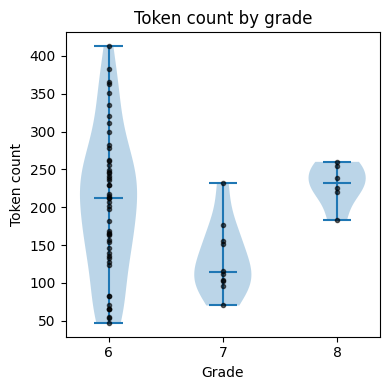

In [12]:
# let's investigate the relationship between grade and token count
grades = []
data = []
for grade, group in embed_df.groupby("grade"):
    list = group.db_string_token_count.tolist()
    grades.append(grade)
    data.append(list)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.violinplot(data, showmedians=True)
for x, values in zip([1, 2, 3], data):
    ax.scatter(
        [
            x,
        ]
        * len(values),
        values,
        color="black",
        marker=".",
        zorder=20,
        alpha=0.6,
    )
ax.set_title("Token count by grade")
ax.set_xlabel("Grade")
ax.set_ylabel("Token count")
ax.set_xticks([1, 2, 3], labels=grades)

fig.tight_layout()
plt.show()

In [75]:
embedding_model = "text-embedding-ada-002"

# remove new-lines to improve performance, according to OpenAI
texts = [row.db_string.replace("\n", " ") for row in embed_df.itertuples()]

result = openai.Embedding.create(input=texts, engine=embedding_model)

In [78]:
result.usage

<OpenAIObject at 0x28c290a40> JSON: {
  "prompt_tokens": 13323,
  "total_tokens": 13323
}

In [85]:
embeddings = [np.array(d["embedding"]) for d in result.data]
assert all([e.shape == (1536,) for e in embeddings])
len(embeddings)

67

In [98]:
db = np.concatenate([e.reshape(1, -1) for e in embeddings], axis=0)
db.shape

(67, 1536)

In [100]:
embed_df.to_parquet(embedding_dir / "rori_embed_df.parquet")
np.save(embedding_dir / "rori_embed_db.npy", db)

### Embed questions to use as queries

In [104]:
ds = []
for row in df.itertuples():
    for question in row.questions:
        text = question["question"] + "\n\n" + question["hint"]
        ds.append(
            {
                "target_lesson_code": row.lesson_code,
                "target_domain": row.domain,
                "target_grade": row.grade,
                "target_construct": row.construct,
                "target_subconstruct": row.subconstruct,
                "query": text,
            }
        )
query_df = pd.DataFrame(ds)
query_df.shape

(664, 6)

In [106]:
embedding_model = "text-embedding-ada-002"
texts = [row.query.replace("\n", " ") for row in query_df.itertuples()]
result = openai.Embedding.create(input=texts, engine=embedding_model)

In [107]:
embeddings = [np.array(d["embedding"]) for d in result.data]
query_db = np.concatenate([e.reshape(1, -1) for e in embeddings], axis=0)
query_db.shape

(664, 1536)

In [108]:
query_df.to_parquet(embedding_dir / "rori_query_df.parquet")
np.save(embedding_dir / "rori_query_db.npy", query_db)

### Code for eval

In [94]:
def get_gpd_codes(lesson_code):
    """
    Structure is: G<grade>.<domain><construct>.<subconstruct>.<skill>.<index>

    e.g. G9.N5.1.3.1 has:
        grade 9
        domain N
        construct N5
        subconstruct N5.1
        skill N5.1.3
        index 1
    """
    tokens = lesson_code.split(".")
    grade = int(tokens[0][1])
    index = int(tokens[-1])

    skill = ".".join(tokens[1:-1])

    domain = tokens[1][0]
    construct = tokens[1]
    subconstruct = tokens[1] + "." + tokens[2]
    return grade, domain, construct, subconstruct, skill, index


get_gpd_codes("G9.N5.1.3.1"), get_gpd_codes("G9.N0.0.0.1")

((9, 'N', 'N5', 'N5.1', 'N5.1.3', 1), (9, 'N', 'N0', 'N0.0', 'N0.0.0', 1))

### Load and query the embedding DB

In [8]:
embed_df = pd.read_parquet(embedding_dir / "rori_embed_df.parquet")
db = np.load(embedding_dir / "rori_embed_db.npy")
embed_df.shape, db.shape

((67, 4), (67, 1536))

In [9]:
query_df = pd.read_parquet(embedding_dir / "rori_query_df.parquet")
query_db = np.load(embedding_dir / "rori_query_db.npy")
query_df.shape, query_db.shape

((664, 6), (664, 1536))

#### Sparse indexing with Anserini

In [12]:
# convert to pyserini format
sparse_dir = embedding_dir / "rori_sparse"
sparse_dir.mkdir(exist_ok=True)
sparse_input_dir = sparse_dir / "input"
sparse_index_dir = sparse_dir / "index"
sparse_input_dir.mkdir(exist_ok=True)
sparse_index_dir.mkdir(exist_ok=True)
with open(sparse_input_dir / "rori_embed_sparse.jsonl", "w") as outfile:
    for row in embed_df.itertuples():
        doc = {
            "id": row.lesson_code,
            "contents": row.db_string,
        }
        outfile.write(json.dumps(doc) + "\n")

In [13]:
# Should end with something like:
# 2023-06-28 14:26:44,134 INFO  [main] index.IndexCollection (IndexCollection.java:587) - Total 67 documents indexed in 00:00:00
!python -m pyserini.index.lucene \
  --collection JsonCollection \
  --input {sparse_input_dir} \
  --index {sparse_index_dir} \
  --generator DefaultLuceneDocumentGenerator \
  --threads 1 \
  --storePositions --storeDocvectors --storeRaw

2023-06-28 14:29:40,621 INFO  [main] index.IndexCollection (IndexCollection.java:380) - Setting log level to INFO
2023-06-28 14:29:40,622 INFO  [main] index.IndexCollection (IndexCollection.java:383) - Starting indexer...
2023-06-28 14:29:40,622 INFO  [main] index.IndexCollection (IndexCollection.java:384) - ============ Loading Parameters ============
2023-06-28 14:29:40,622 INFO  [main] index.IndexCollection (IndexCollection.java:385) - DocumentCollection path: ../data/derived/embeddings/rori_sparse/input
2023-06-28 14:29:40,622 INFO  [main] index.IndexCollection (IndexCollection.java:386) - CollectionClass: JsonCollection
2023-06-28 14:29:40,622 INFO  [main] index.IndexCollection (IndexCollection.java:387) - Generator: DefaultLuceneDocumentGenerator
2023-06-28 14:29:40,622 INFO  [main] index.IndexCollection (IndexCollection.java:388) - Threads: 1
2023-06-28 14:29:40,622 INFO  [main] index.IndexCollection (IndexCollection.java:389) - Language: en
2023-06-28 14:29:40,622 INFO  [main] 

In [41]:
searcher = LuceneSearcher(str(sparse_index_dir.resolve()))

In [42]:
searcher.is_using_rm3(), searcher.is_using_rocchio()

(False, False)

In [43]:
hits = searcher.search("probability example", k=20)
len(hits)

20

In [45]:
hits[0].docid

'G6.S2.1.2.1'

In [46]:
hits[0].score, hits[-1].score

(3.583699941635132, 0.3246000111103058)

In [47]:
# assume the top 3 documents are relevant
# then identify 3 terms to expand the query with
# weighting original query scores vs revised query scores by 0.5
searcher.set_rm3(fb_terms=3, fb_docs=3, original_query_weight=0.5)

In [48]:
hits = searcher.search("probability example", k=20)
hits[0].score, hits[-1].score

(2.5209999084472656, 0.08110000193119049)

In [49]:
# via RM3 query expansion
searcher.get_feedback_terms("probability")

{'outcom': 0.21739129722118378,
 'probabl': 0.6304348111152649,
 'event': 0.15217390656471252}

#### Evaluation

In [125]:
def query_embedding_db(query_embedding, db, db_df):
    return False


query_embedding = query_db[0, :].reshape(1, -1)

distances = scipy.spatial.distance.cdist(query_embedding, db, metric="cosine")[0]

In [126]:
scipy.stats.rankdata(distances, method="max")

array([ 1,  4, 61, 35, 51, 34, 32, 28, 57, 66, 63, 30, 65, 50, 67, 53, 62,
       64, 54, 49, 26, 21, 36, 17, 42, 44, 24, 16, 25, 33, 40, 31,  3, 29,
       19, 43, 12, 59, 15, 23, 46,  7, 11,  6,  8, 27, 38, 18, 10, 56, 58,
       48, 45, 60, 13, 20, 55, 41, 37,  9,  5, 14, 22,  2, 52, 39, 47])

In [130]:
sort_inds = np.argsort(distances)
sort_inds

array([ 0, 63, 32,  1, 60, 43, 41, 44, 59, 48, 42, 36, 54, 61, 38, 27, 23,
       47, 34, 55, 21, 62, 39, 26, 28, 20, 45,  7, 33, 11, 31,  6, 29,  5,
        3, 22, 58, 46, 65, 30, 57, 24, 35, 25, 52, 40, 66, 51, 19, 13,  4,
       64, 15, 18, 56, 49,  8, 50, 37, 53,  2, 16, 10, 17, 12,  9, 14])

In [135]:
smallest_distances = distances[sort_inds[:3]]
smallest_distances

array([0.15034087, 0.17756433, 0.18582566])

In [136]:
embed_df.lesson_code.iloc[sort_inds[:3]]

0     G8.A2.1.2.1
63    G7.N4.2.2.1
32    G6.N1.3.7.1
Name: lesson_code, dtype: object

In [68]:
index_lesson_code_map = embed_df.lesson_code.to_dict()
lesson_code_index_map = {v: k for k, v in index_lesson_code_map.items()}
target_index = lesson_code_index_map[query_df.iloc[0].target_lesson_code]
target_index

0

In [70]:
# create pyserini searchers
bm25_searcher = LuceneSearcher(str(sparse_index_dir.resolve()))
bm25_rm3_searcher = LuceneSearcher(str(sparse_index_dir.resolve()))
bm25_rm3_searcher.set_rm3(fb_terms=3, fb_docs=3, original_query_weight=0.5)

In [133]:
assert len(query_db) == len(query_df)
rs = []
k = 20
for query_ind in tqdm(range(len(query_df))):
    query_row = query_df.iloc[query_ind]
    target_lesson_code = query_row.target_lesson_code
    target_index = lesson_code_index_map[target_lesson_code]

    for method in ["cossim", "bm25", "bm25_rm3", "random"]:
        if method == "cossim":
            query_embedding = query_db[query_ind, :].reshape(1, -1)
            distances = scipy.spatial.distance.cdist(query_embedding, db, metric="cosine")[0]
        elif method.startswith("bm25"):
            query_str = query_row.query
            if method == "bm25":
                hits = bm25_searcher.search(query_str, k=len(db))
            elif method == "bm25_rm3":
                hits = bm25_rm3_searcher.search(query_str, k=len(db))
            distances = np.zeros(len(db))
            for hit in hits:
                ind = lesson_code_index_map[hit.docid]
                distances[ind] = hit.score
            distances = distances.max() - distances
        elif method == "random":
            distances = np.random.random(len(db))
            distances = distances.max() - distances
        else:
            raise ValueError("Not implemented.")

        sort_inds = np.argsort(distances)
        ranks = scipy.stats.rankdata(distances, method="max")

        top_k_indices = sort_inds[:k]
        top_k_scores = distances[top_k_indices]
        assert top_k_indices.shape == top_k_scores.shape

        target_rank = ranks[target_index]
        r = {
            "method": method,
            "query_ind": query_ind,
            "target_lesson_code": target_lesson_code,
            "target_index": target_index,
            "target_rank": target_rank,
            "top_k_indices": top_k_indices,
            "top_k_scores": top_k_scores,
        }
        rs.append(r)
eval_df = pd.DataFrame(rs)
eval_df["reciprocal_rank"] = 1 / eval_df.target_rank
eval_df.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 664/664 [00:01<00:00, 387.15it/s]


(2656, 8)

In [134]:
eval_df.sample(n=2)

,method,query_ind,target_lesson_code,target_index,target_rank,top_k_indices,top_k_scores,reciprocal_rank
2327,random,581,G7.N4.1.1.1,58,17,"[52, 29, 36, 3, 45, 32, 43, 47, 51, 27, 46, 57...","[0.0, 0.006898671157708591, 0.0073079533533039...",0.058824
1486,bm25_rm3,371,G6.N2.1.4.7,37,1,"[37, 41, 38, 39, 44, 40, 42, 48, 43, 47, 45, 5...","[0.0, 0.5625000596046448, 0.7290000319480896, ...",1.000000


In [153]:
scores = []
for row in eval_df.itertuples():
    indices = row.top_k_indices
    lesson_codes = [index_lesson_code_map[ind] for ind in indices]
    scoring_values = []
    for lesson_code in lesson_codes:
        grade, domain, construct, subconstruct, skill, _ = get_gpd_codes(lesson_code)
        # note: could look up other metadata here from the lesson code, if desired
        scoring_values.append(
            {
                "lesson_code": lesson_code,
                "grade": grade,
                "domain": domain,
                "construct": construct,
                "subconstruct": subconstruct,
                "skill": skill,
            }
        )
    target_lesson_code = row.target_lesson_code
    grade, domain, construct, subconstruct, skill, _ = get_gpd_codes(target_lesson_code)
    target_value = {
        "lesson_code": target_lesson_code,
        "grade": grade,
        "domain": domain,
        "construct": construct,
        "subconstruct": subconstruct,
        "skill": skill,
    }
    for value_name in ["grade", "lesson_code", "domain", "construct", "subconstruct", "skill"]:
        matches = []
        for scoring_value in scoring_values:
            is_match = scoring_value[value_name] == target_value[value_name]
            matches.append(is_match)
        matches = np.array(matches)
        for i in range(1, k + 1):
            n_matches = matches[:i].sum()
            has_hit = n_matches > 0
            if has_hit:
                rank = matches.nonzero()[0][0] + 1
                assert rank > 0, matches
                reciprocal_rank = 1 / rank
            else:
                reciprocal_rank = 0
            precision = n_matches / i
            scores.append(
                {
                    "method": row.method,
                    "query_ind": row.query_ind,
                    "value_name": value_name,
                    "k": i,
                    "precision": precision,
                    "reciprocal_rank": reciprocal_rank,
                    "has_hit": has_hit,
                    **target_value,
                }
            )
score_df = pd.DataFrame(scores)
score_df.shape

(318720, 13)

In [154]:
score_df.sample(n=5)

,method,query_ind,value_name,k,precision,reciprocal_rank,has_hit,lesson_code,grade,domain,construct,subconstruct,skill
122646,bm25_rm3,255,grade,7,1.000000,1.000000,True,G6.N1.2.3.1,6,N,N1,N1.2,N1.2.3
241644,bm25,503,subconstruct,5,0.200000,0.333333,True,G6.N3.1.2.2,6,N,N3,N3.1,N3.1.2
60430,random,125,construct,11,0.090909,0.100000,True,G6.M2.2.3.1,6,M,M2,M2.2,M2.2.3
3715,bm25_rm3,7,skill,16,0.062500,1.000000,True,G8.A2.1.2.1,8,A,A2,A2.1,A2.1.2
61392,random,127,construct,13,0.076923,0.083333,True,G6.M2.2.3.1,6,M,M2,M2.2,M2.2.3


In [155]:
score_df.columns

Index(['method', 'query_ind', 'value_name', 'k', 'precision',
       'reciprocal_rank', 'has_hit', 'lesson_code', 'grade', 'domain',
       'construct', 'subconstruct', 'skill'],
      dtype='object')

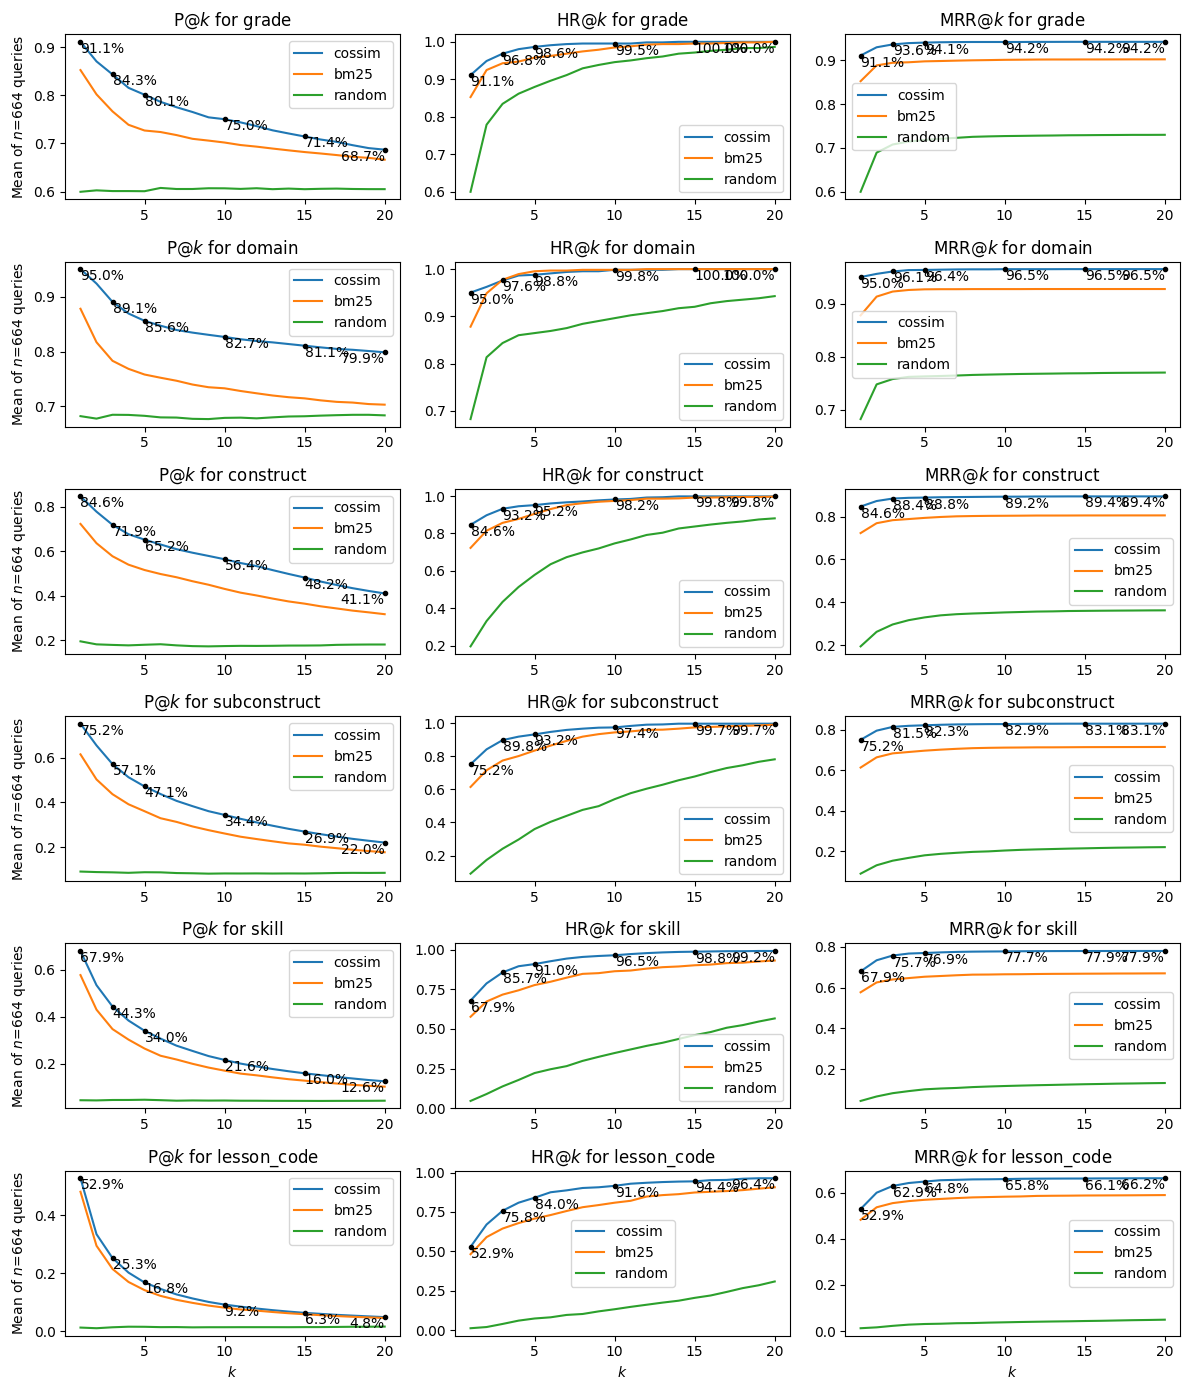

In [157]:
metrics = ["P@$k$", "HR@$k$", "MRR@$k$"]
value_names = ["grade", "domain", "construct", "subconstruct", "skill", "lesson_code"]
fig, axes = plt.subplots(len(value_names), len(metrics), figsize=(12, 14))

xs = []
for i in range(1, k + 1):
    xs.append(i)

for row_ind, value_name in enumerate(value_names):
    for col_ind, metric in enumerate(metrics):
        ax = axes[row_ind, col_ind]
        for method in ["cossim", "bm25", "random"]:
            ys = []
            for i in range(1, k + 1):
                sdf = score_df[(score_df.value_name == value_name) & (score_df.method == method) & (score_df.k == i)]
                # .sample(frac=1).drop_duplicates(subset="lesson_code", keep="first")
                if metric == "HR@$k$":
                    m = sdf.has_hit.mean()
                elif metric == "MRR@$k$":
                    m = sdf.reciprocal_rank.mean()
                else:
                    m = sdf.precision.mean()
                ys.append(m)

            assert len(xs) == len(ys)

            ax.plot(xs, ys, label=f"{method}")

            if method == "cossim":
                for n in [1, 3, 5, 10, 15, 20]:
                    ax.scatter(n, ys[n - 1], color="black", zorder=10, marker=".")
                    ax.text(n, ys[n - 1], f"{ys[n-1]:.1%}", va="top", ha="left" if n < 20 else "right")

        ax.set_title(f"{metric} for {value_name}")
        if row_ind == len(value_names) - 1:
            ax.set_xlabel("$k$")
        if col_ind == 0:
            ax.set_ylabel(f"Mean of $n$={len(sdf)} queries")

        ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
# TODO group by target domain (or construct...)
# and compute some specific metrics to make a table
# e.g. fo

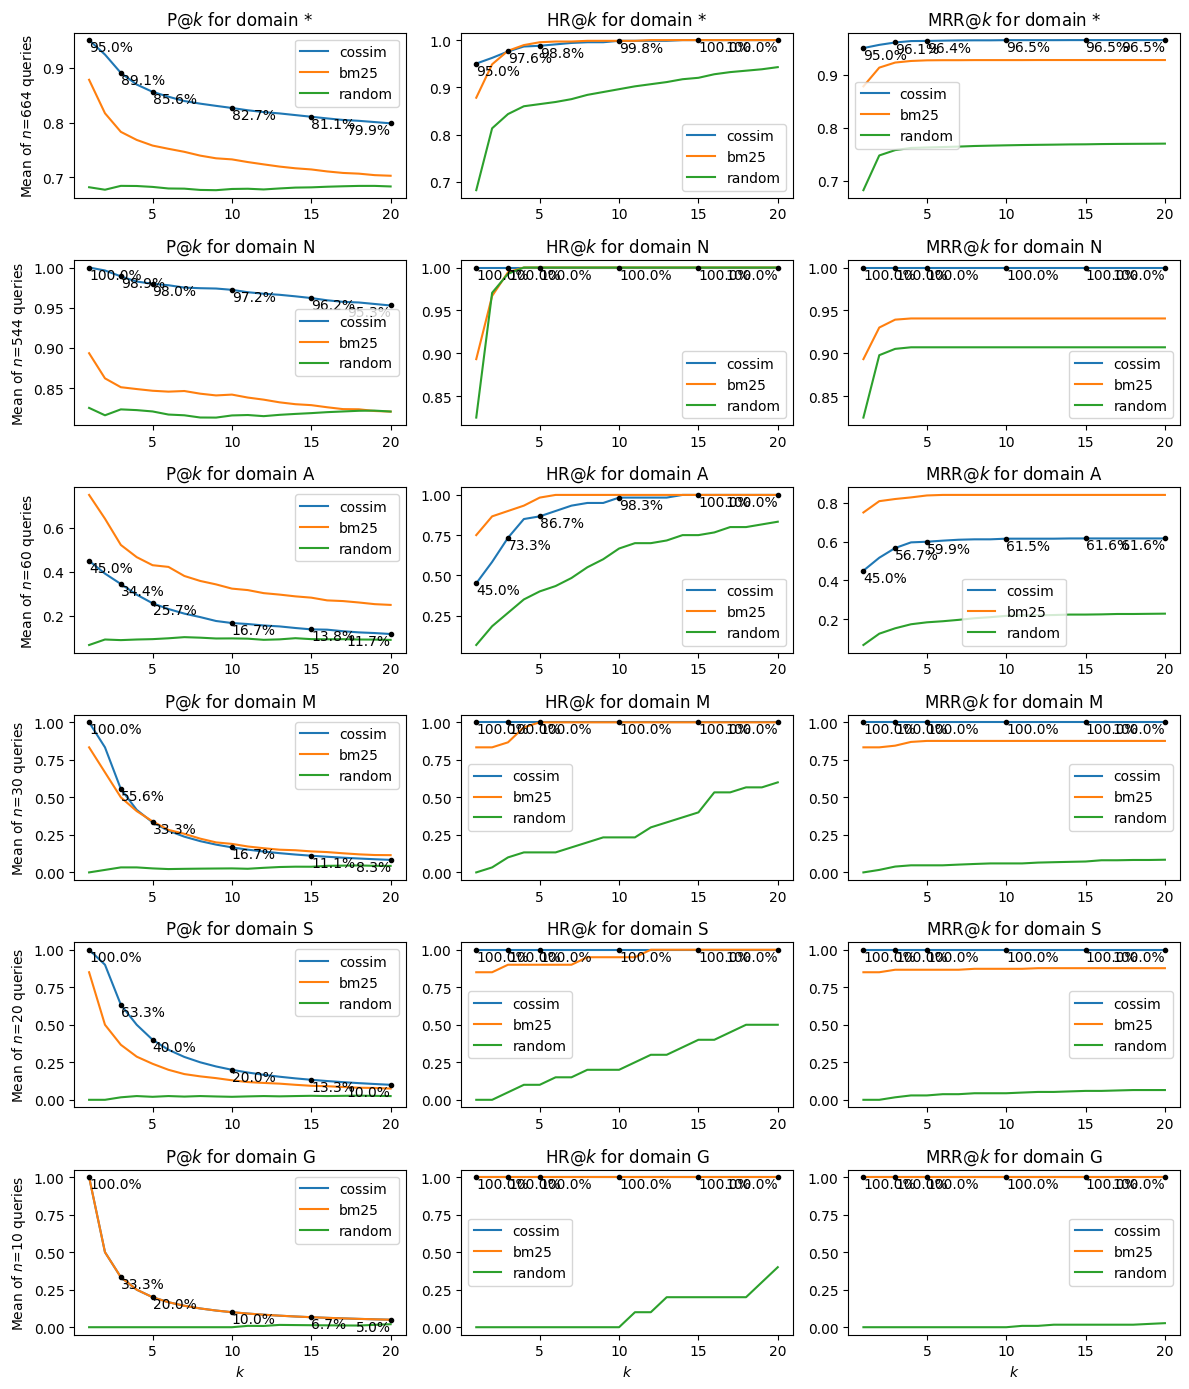

In [169]:
subset_col_name = "domain"
group_counts = score_df[subset_col_name].value_counts()
nrows = len(group_counts) + 1

metrics = ["P@$k$", "HR@$k$", "MRR@$k$"]
fig, axes = plt.subplots(nrows, len(metrics), figsize=(12, 14))

xs = []
for i in range(1, k + 1):
    xs.append(i)

for row_ind, group_name in enumerate(
    [
        "*",
    ]
    + list(group_counts.to_dict().keys())
):
    for col_ind, metric in enumerate(metrics):
        ax = axes[row_ind, col_ind]
        for method in ["cossim", "bm25", "random"]:
            ys = []
            for i in range(1, k + 1):
                if group_name == "*":
                    sdf = score_df[
                        (score_df.value_name == subset_col_name) & (score_df.method == method) & (score_df.k == i)
                    ]
                else:
                    sdf = score_df[
                        (score_df.value_name == subset_col_name)
                        & (score_df[subset_col_name] == group_name)
                        & (score_df.method == method)
                        & (score_df.k == i)
                    ]
                if metric == "HR@$k$":
                    m = sdf.has_hit.mean()
                elif metric == "MRR@$k$":
                    m = sdf.reciprocal_rank.mean()
                else:
                    m = sdf.precision.mean()
                ys.append(m)

            assert len(xs) == len(ys)

            ax.plot(xs, ys, label=f"{method}")

            if method == "cossim":
                for n in [1, 3, 5, 10, 15, 20]:
                    ax.scatter(n, ys[n - 1], color="black", zorder=10, marker=".")
                    ax.text(n, ys[n - 1], f"{ys[n-1]:.1%}", va="top", ha="left" if n < 20 else "right")

        ax.set_title(f"{metric} for {subset_col_name} {group_name}")
        if row_ind == nrows - 1:
            ax.set_xlabel("$k$")
        if col_ind == 0:
            ax.set_ylabel(f"Mean of $n$={len(sdf)} queries")

        ax.legend()

fig.tight_layout()
plt.show()

In [109]:
sklearn.metrics.ndcg_score([])

In [53]:
eval_df.reciprocal_rank.mean()

0.6632352554320463

In [54]:
eval_df.groupby("target_lesson_code").mean()

,query_ind,target_index,target_rank,reciprocal_rank
target_lesson_code,,,,
G6.A1.1.2.1,84.5,8.0,3.5,0.370833
G6.A1.1.3.1,74.5,7.0,5.8,0.625776
G6.A1.1.4.1,64.5,6.0,8.7,0.387288
G6.A3.1.1.1,54.5,5.0,1.6,0.766667
G6.G1.1.3.1,114.5,11.0,1.0,1.000000
...,...,...,...,...
G8.A2.1.2.1,4.5,0.0,2.0,0.650000
G8.N3.2.4.1,24.5,2.0,2.4,0.466667
G8.N3.2.4.2,638.5,64.0,1.9,0.797619


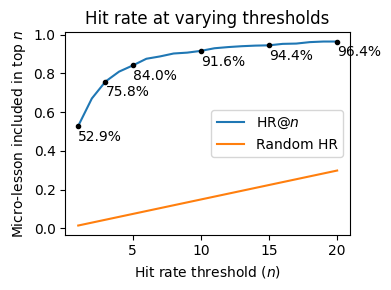

In [55]:
xs = []
ys = []
for n in range(1, 21):
    hr = (eval_df.target_rank <= n).sum() / len(eval_df)
    xs.append(n)
    ys.append(hr)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

ax.plot(xs, ys, label="HR@$n$")

random_ys = [x / len(embed_df) for x in xs]
ax.plot(xs, random_ys, label="Random HR")

for n in [1, 3, 5, 10, 15, 20]:
    ax.scatter(n, ys[n - 1], color="black", zorder=10, marker=".")
    ax.text(n, ys[n - 1] - 0.02, f"{ys[n-1]:.1%}", va="top", ha="left")

ax.set_title("Hit rate at varying thresholds")
ax.set_xlabel("Hit rate threshold ($n$)")
ax.set_ylabel("Micro-lesson included in top $n$")

ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
# TODO at some threshold, compute NDGC, Accuracy, etc. for the other grouping criteria
# (grade, domain, construct, subconstruct, skill)

In [ ]:
I don't get binomial form

In [ ]:
HEre's hte most recent lesson the student did:
-=----

Here's the most relevant micro-lesson to this student's question:
1 ------
2 ------

Give a useful, informative repsonse.

In [ ]:
Anserini - Pyserini